Saved:
 - combined_networks_surf_root_overlay.png
 - combined_networks_delta_from_control_overlay.png


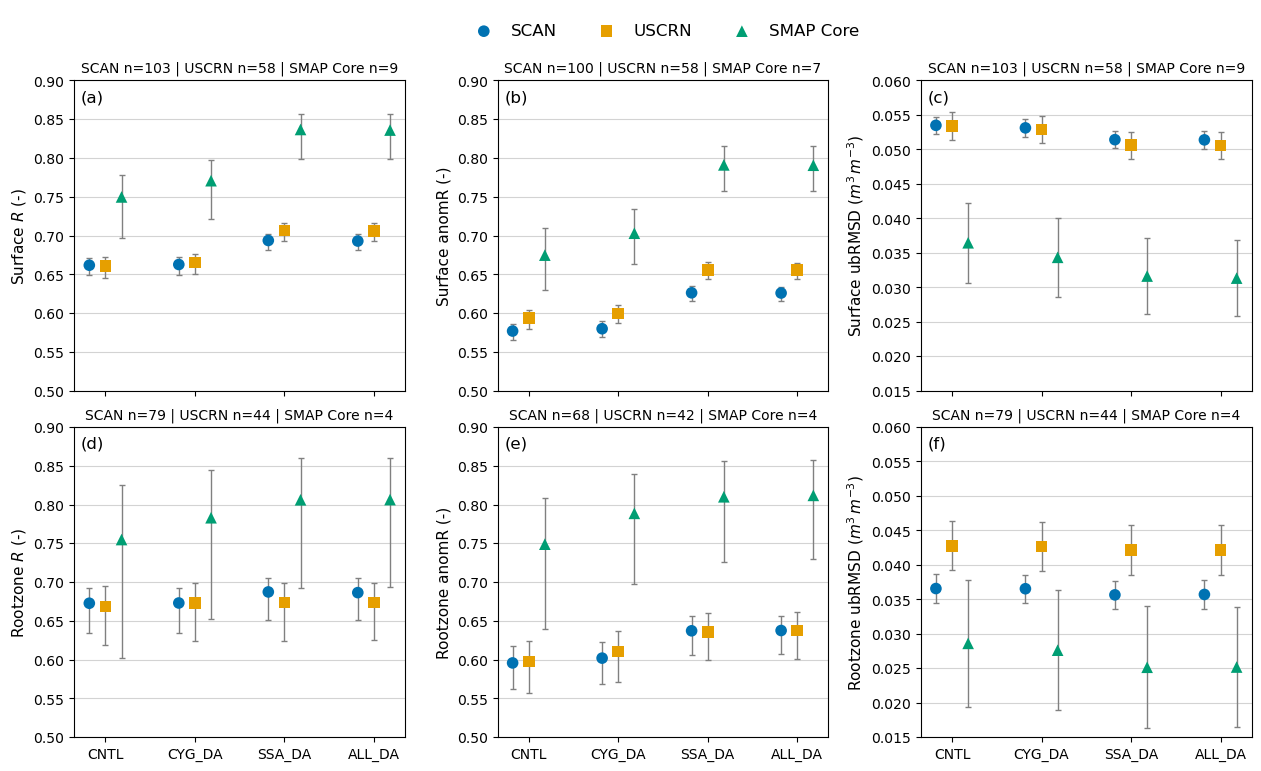

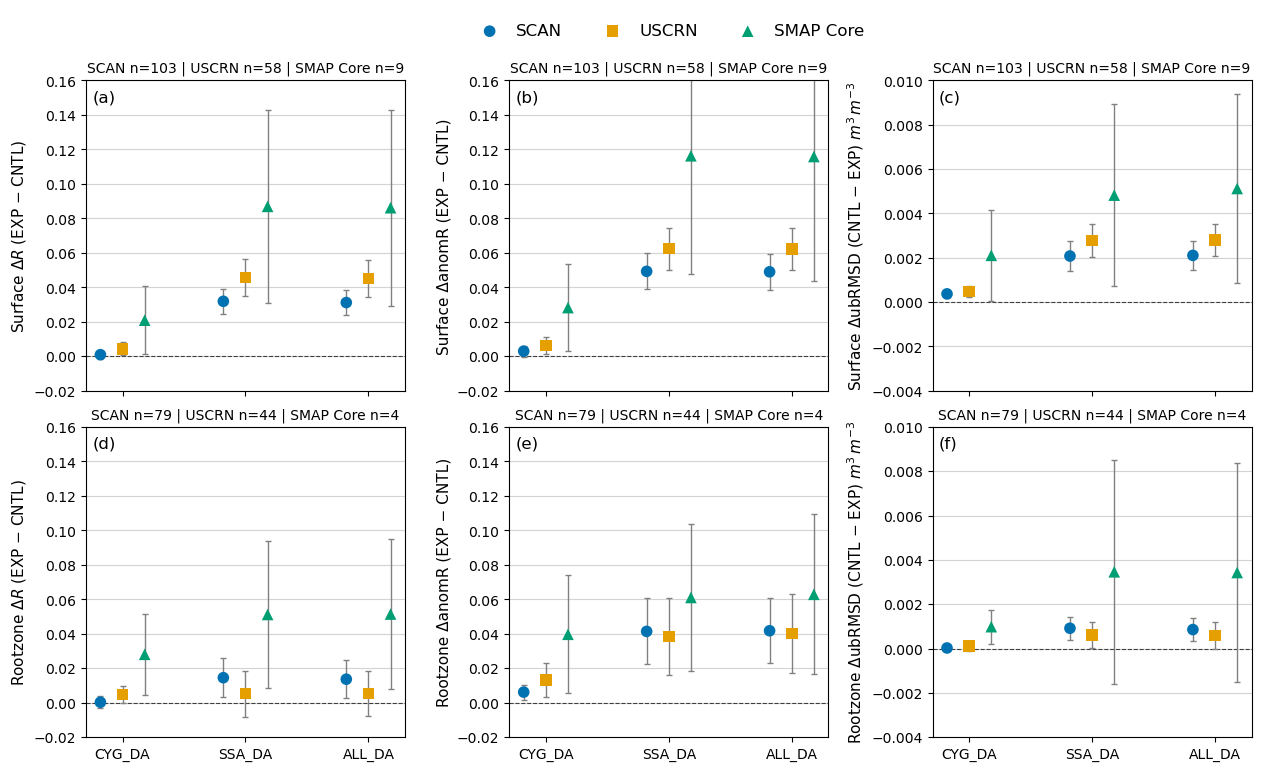

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import t
from pathlib import Path

# ===============================
# CONFIG
# ===============================

DATA_DIR = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data")

BASE_DIR = Path(DATA_DIR, "CYGNSS_Experiments/Evaluation/InSitu/output")

# Experiments (order -> x-axis)
# experiment_names = ["OLv8_M36_cd", "DAv8_M36_cd", "DAv8_M36_cd_ssa", "DAv8_M36_cd_all"]
# expt_labels = ["CNTL", "CYG_DA", "SSA_DA", "ALL_DA"]

experiment_names = ["OLv8_M36_cd", "DAv8_M36_cd", "DAv8_M36_cd_ssa_fixed", "DAv8_M36_cd_all_fixed"]
expt_labels = ["CNTL", "CYG_DA", "SSA_DA", "ALL_DA"] 

# Networks to combine: (insitu_tag_in_filename, label)
networks = [
    ("_SCAN_SM_1d_c1234smv_6yr", "SCAN"),
    ("_USCRN_SM_1d_c1234smv_6yr", "USCRN"),
    ("_CalVal_M33_SM_1d__6yr", "SMAP Core"),
]

# Plot look
title_fs = 15
label_fs = 11
tick_fs  = 10
legend_fs = 12
dot_size = 70
capsize = 2

# Okabe–Ito palette (3 distinct)
palette = {"SCAN": "#0072B2", "USCRN": "#E69F00", "SMAP Core": "#009E73"}
markers = {"SCAN": "o", "USCRN": "s", "SMAP Core": "^"}

# Panels and y-lims for raw means
panel_info_means = [
    ("R",      r"$R$ (-)",                (0.50, 0.90)),
    ("anomR",  r"anomR (-)",              (0.50, 0.90)),
    ("ubRMSE", r"ubRMSD ($m^3\,m^{-3}$)", (0.015, 0.060)),
]

# Panels and y-lims for deltas (tweak if needed)
panel_info_delta = [
    ("R",      r"Δ$R$ (EXP − CNTL)",                      (-0.02, 0.16)),
    ("anomR",  r"ΔanomR (EXP − CNTL)",                    (-0.02, 0.16)),
    ("ubRMSE", r"ΔubRMSD (CNTL − EXP) $m^3\,m^{-3}$",     (-0.004, 0.010)),
]

# ===============================
# HELPERS
# ===============================
def reduce_metric_means_ci(arr, lo, up):
    """
    Compute mean across sites and CI magnitudes as in your original script:
    CI_magnitudes ≈ mean(LO or UP)/sqrt(N_nonNaN).
    Returns:
      mean: (depth,)
      ci_mag: (2, depth)  (lower, upper) magnitudes (non-negative)
      n: (depth,) integer counts of non-NaN sites
    """
    mean = np.nanmean(arr, axis=0)                  # (depth,)
    n = np.sum(~np.isnan(arr), axis=0)              # (depth,)
    denom = np.sqrt(np.maximum(n, 1))
    ci_lo = np.nanmean(lo, axis=0) / denom
    ci_up = np.nanmean(up, axis=0) / denom
    ci_mag = np.vstack([np.abs(ci_lo), np.abs(ci_up)])
    return mean, ci_mag, n

def paired_delta_stats(arr_cntl, arr_exp, up_is_better=True, alpha=0.05):
    """
    Paired per-site differences and t-intervals (statistically correct).
    arr_cntl, arr_exp: (sites, depth)
    up_is_better=True -> Δ = EXP - CNTL; False -> Δ = CNTL - EXP (e.g., ubRMSE)
    Returns:
      mean_delta: (depth,)
      ci_half:   (depth,) symmetric t CI half-width (magnitude)
      n_eff:     (depth,) paired counts
    """
    sign = +1 if up_is_better else -1
    D = sign * (arr_exp - arr_cntl)                 # (sites, depth)
    # mask to paired non-NaN per depth
    mask = (~np.isnan(arr_cntl)) & (~np.isnan(arr_exp))
    depth = arr_cntl.shape[1]
    mean_delta = np.full(depth, np.nan)
    ci_half = np.full(depth, 0.0)
    n_eff = np.zeros(depth, dtype=int)

    for d in range(depth):
        m = mask[:, d]
        if not np.any(m):
            continue
        di = D[m, d]
        n = di.size
        n_eff[d] = n
        dbar = np.nanmean(di)
        sd = np.nanstd(di, ddof=1) if n > 1 else 0.0
        se = sd / np.sqrt(max(n, 1))
        k = t.ppf(1 - alpha/2, df=max(n-1, 1))
        mean_delta[d] = dbar
        ci_half[d] = k * se
    return mean_delta, ci_half, n_eff

def plot_overlay(
    means_dict, cis_dict, Ns_dict, panel_info, outfile,
    title_suffix="", expt_idx=None, x_tick_labels=None
):
    """
    means_dict[m]: [net, depth, expt]
    cis_dict[m]:   [net, 2(lo,up), depth, expt]  (magnitudes)
    Ns_dict[m]:    [net, depth, expt]
    expt_idx:      list/array of experiment indices to plot (default: all)
    x_tick_labels: labels matching expt_idx (default: expt_labels[expt_idx])
    """
    num_networks = len(networks)
    all_idx = np.arange(len(expt_labels))
    if expt_idx is None:
        expt_idx = all_idx
    expt_idx = np.asarray(expt_idx)
    if x_tick_labels is None:
        x_tick_labels = [expt_labels[i] for i in expt_idx]

    fig = plt.figure(figsize=(12.5, 7.6), constrained_layout=True)
    mosaic = [
        ["legend", "legend", "legend"],
        ["s0", "s1", "s2"],
        ["r0", "r1", "r2"],
    ]
    axs = fig.subplot_mosaic(
            mosaic,
            gridspec_kw={"height_ratios": [0.14, 1.0, 1.0]}
            )
    
    # Add panel labels
    labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
    label_keys = ["s0", "s1", "s2", "r0", "r1", "r2"]
    for lab, key in zip(labels, label_keys):
        axs[key].text(0.02, 0.97, lab, transform=axs[key].transAxes,
                      fontsize=12, fontweight="normal", va="top", ha="left")
    ax_leg = axs["legend"]; ax_leg.axis("off")

    x = np.arange(len(expt_idx))
    offsets = np.linspace(-0.18, 0.18, num_networks)

    for col, (metric_key, ylab, ylim) in enumerate(panel_info):
        for depth in [0, 1]:
            ax = axs[("s" if depth == 0 else "r") + str(col)]
            ax.grid(axis="y", color="lightgrey", zorder=0)
            ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.7, zorder=1)
            ax.set_axisbelow(True)

            for ni, (_, nlabel) in enumerate(networks):
                y  = means_dict[metric_key][ni, depth, expt_idx]
                xpos = x + offsets[ni]

                ci = np.asarray(cis_dict[metric_key][ni, :, depth, expt_idx], dtype=float)
                if ci.ndim == 0:                    # scalar -> (2,1)
                    val = float(ci)
                    ci = np.array([[val], [val]])
                elif ci.ndim == 1:                  # (N,) -> (2,N) symmetric
                    ci = np.vstack([ci, ci])
                elif ci.ndim == 2 and ci.shape[0] != 2:  # (N,2) -> (2,N)
                    ci = ci.T

                ax.scatter(xpos, y, s=dot_size, marker=markers[nlabel],
                           color=palette[nlabel], edgecolor="none", zorder=3,
                           label=nlabel if (depth==0 and col==0) else None)
                ax.errorbar(xpos, y, yerr=ci, fmt="none", ecolor="gray",
                            elinewidth=1.0, capsize=capsize, zorder=2)

            ax.set_ylim(*ylim)
            if depth == 1:
                ax.set_xticks(x, x_tick_labels, fontsize=tick_fs)
            else:
                ax.set_xticks(x, [""] * len(x_tick_labels))

            layer = "Surface" if depth == 0 else "Rootzone"
            ax.set_ylabel(f"{layer} {ylab}", fontsize=label_fs)

            # Title: ONLY n per network (from CNTL), fontsize=10
            ntext = " | ".join(
                f"{networks[ni][1]} n={int(Ns_dict[metric_key][ni, depth, 0])}"
                for ni in range(num_networks)
            )
            ax.set_title(ntext, fontsize=10)

    # Legend centered in slim band
    handles, labels = axs["s0"].get_legend_handles_labels()
    if handles:
        ax_leg.legend(handles, labels, loc="center", ncols=len(labels),
                      fontsize=legend_fs, frameon=False,
                      handletextpad=0.6, borderaxespad=0.0)

    fig.savefig(outfile, dpi=300, bbox_inches="tight", pad_inches=0.04)
    #plt.close(fig)



# ===============================
# LOAD ALL FILES ONCE; BUILD STATS
# ===============================
metrics = ["R", "anomR", "ubRMSE"]
num_expts = len(experiment_names)
num_networks = len(networks)

# Store per-network, per-experiment, per-metric arrays for paired Δ (site x depth)
store_R     = [[None]*num_expts for _ in range(num_networks)]
store_anomR = [[None]*num_expts for _ in range(num_networks)]
store_ub    = [[None]*num_expts for _ in range(num_networks)]

# Containers for RAW means/CI/N
means_raw = {m: np.full((num_networks, 2, num_expts), np.nan) for m in metrics}
cis_raw   = {m: np.full((num_networks, 2, 2, num_expts), np.nan) for m in metrics}  # (net, lo/up, depth, expt)
Ns_raw    = {m: np.zeros((num_networks, 2, num_expts), dtype=int) for m in metrics}

for ni, (tag, nlabel) in enumerate(networks):
    for ei, exname in enumerate(experiment_names):
        fpath = BASE_DIR / f"{exname}{tag}_stats_60.mat"
        mat = sio.loadmat(fpath, squeeze_me=False)

        # Arrays (sites x depth)
        R       = np.asarray(mat["R"])
        RLO     = np.asarray(mat["RLO"])
        RUP     = np.asarray(mat["RUP"])
        anomR   = np.asarray(mat["anomR"])
        anomRLO = np.asarray(mat["anomRLO"])
        anomRUP = np.asarray(mat["anomRUP"])
        ub      = np.asarray(mat["ubRMSE"])
        ubLO    = np.asarray(mat["ubRMSELO"])
        ubUP    = np.asarray(mat["ubRMSEUP"])

        # Save for paired Δ later
        store_R[ni][ei]     = R
        store_anomR[ni][ei] = anomR
        store_ub[ni][ei]    = ub

        # Raw means & CI magnitudes (following your earlier approach)
        for key, arrs in {
            "R":      (R, RLO, RUP),
            "anomR":  (anomR, anomRLO, anomRUP),
            "ubRMSE": (ub, ubLO, ubUP),
        }.items():
            m, ci2, n = reduce_metric_means_ci(*arrs)
            means_raw[key][ni, :, ei] = m
            cis_raw[key][ni, :, :, ei] = ci2
            Ns_raw[key][ni, :, ei] = n

# ===============================
# FIGURE 1: RAW MEANS (overlay)
# ===============================
plot_overlay(means_raw, cis_raw, Ns_raw, panel_info_means,
             "combined_networks_surf_root_overlay.png", title_suffix="")

# ===============================
# FIGURE 2: Δ FROM CONTROL (overlay, paired per-site t CIs)
# ===============================
# Build Δ vs CNTL for each network/experiment using site-paired differences.
delta_means = {m: np.zeros_like(means_raw[m]) for m in metrics}  # same shapes
delta_cis   = {m: np.zeros_like(cis_raw[m])   for m in metrics}
Ns_delta    = {m: np.zeros_like(Ns_raw[m])    for m in metrics}

for ni in range(num_networks):
    # reference CNTL (ei=0)
    R_cntl     = store_R[ni][0]
    anomR_cntl = store_anomR[ni][0]
    ub_cntl    = store_ub[ni][0]

    # Set Δ at CNTL = 0 with 0 CI
    for key in metrics:
        delta_means[key][ni, :, 0] = 0.0
        delta_cis[key][ni, :, :, 0] = 0.0
        Ns_delta[key][ni, :, 0] = np.sum(~np.isnan(store_R[ni][0]), axis=0)  # any metric; counts of CNTL available

    # Other experiments (ei >= 1)
    for ei in range(1, num_expts):
        # R and anomR: Δ = EXP - CNTL (up is better)
        md, hw, n = paired_delta_stats(R_cntl, store_R[ni][ei], up_is_better=True)
        delta_means["R"][ni, :, ei] = md
        delta_cis["R"][ni, 0, :, ei] = hw  # lower mag
        delta_cis["R"][ni, 1, :, ei] = hw  # upper mag
        Ns_delta["R"][ni, :, ei] = n

        md, hw, n = paired_delta_stats(anomR_cntl, store_anomR[ni][ei], up_is_better=True)
        delta_means["anomR"][ni, :, ei] = md
        delta_cis["anomR"][ni, 0, :, ei] = hw
        delta_cis["anomR"][ni, 1, :, ei] = hw
        Ns_delta["anomR"][ni, :, ei] = n

        # ubRMSE: improvement = CNTL - EXP (up is better)
        md, hw, n = paired_delta_stats(ub_cntl, store_ub[ni][ei], up_is_better=False)
        delta_means["ubRMSE"][ni, :, ei] = md
        delta_cis["ubRMSE"][ni, 0, :, ei] = hw
        delta_cis["ubRMSE"][ni, 1, :, ei] = hw
        Ns_delta["ubRMSE"][ni, :, ei] = n

# Plot Δ overlay
plot_overlay(
    delta_means, delta_cis, Ns_delta, panel_info_delta,
    "combined_networks_delta_from_control_overlay.png",
    title_suffix="Δ from CNTL",
    expt_idx=[1, 2, 3],                         # <- drop CNTL
    x_tick_labels=[expt_labels[i] for i in [1,2,3]]
)

print("Saved:")
print(" - combined_networks_surf_root_overlay.png")
print(" - combined_networks_delta_from_control_overlay.png")


In [12]:
insitu_tag = "_USCRN_SM_1d_c1234smv_6yr"  # Example tag; change as needed

m_rs_file = BASE_DIR / ('OLv8_M36_cd' + insitu_tag + '_raw_timeseries.mat')
mat_contents = sio.loadmat(m_rs_file)

# List of variables and their dimensions in the MATLAB file
print(sio.whosmat(m_rs_file))

vars = [k for k in mat_contents.keys() if not k.startswith('__')]
print('Variables in MAT file:')
for name in vars:
    val = mat_contents[name]
    shp = getattr(val, 'shape', None)
    print(f"{name}: type={type(val).__name__}, shape={shp}")

# ...existing code...

# Align metric arrays with the selected in-situ network
network_idx = next((i for i, (tag, _) in enumerate(networks) if tag == insitu_tag), None)
if network_idx is None:
    available = [tag for tag, _ in networks]
    raise ValueError(f'{insitu_tag} is not in the networks list: {available}')

# Stack per-experiment arrays so we can index as [:, depth, experiment]
R = np.stack(store_R[network_idx], axis=-1)
anomR = np.stack(store_anomR[network_idx], axis=-1)
ubRMSE = np.stack(store_ub[network_idx], axis=-1)


[('INSITU_id', (1, 62), 'cell'), ('INSITU_id_string', (1,), 'char'), ('INSITU_lat', (1, 62), 'double'), ('INSITU_lon', (1, 62), 'double'), ('INSITU_path', (1,), 'char'), ('INSITU_sm', (2161, 2, 62), 'double'), ('INSITU_st', (2161, 5, 62), 'double'), ('INSITU_tag', (1,), 'char'), ('LDAS_prcp_org', (2161, 1, 62), 'double'), ('LDAS_sm_org', (2161, 2, 62), 'double'), ('LDAS_st_org', (2161, 2, 62), 'double'), ('Nmin', (1, 1), 'double'), ('add_anomR', (1, 1), 'double'), ('data_ext', (1,), 'char'), ('date_time', (1, 1), 'struct'), ('date_time_string', (1,), 'char'), ('date_time_vec', (1, 2161), 'struct'), ('date_time_vec1', (1, 1), 'struct'), ('distance', (70773, 1), 'double'), ('distance_min', (1, 62), 'double'), ('domain', (1,), 'char'), ('dtstep', (1, 1), 'double'), ('end_time', (1, 1), 'struct'), ('exp_path', (1,), 'char'), ('exp_run', (1,), 'char'), ('exp_run_name', (2, 1), 'cell'), ('file_ext', (1,), 'char'), ('file_tag', (1,), 'char'), ('fname', (1,), 'char'), ('fname_tilecoord', (1,),

In [13]:
# Extract INSITU_lat from the MATLAB file
INSITU_lat = mat_contents['INSITU_lat']

# Determine the number of sites below 40 degrees N
num_sites_below_40N = np.sum(INSITU_lat < 60)
print(f"Number of sites below 40 degrees N: {num_sites_below_40N}")

Number of sites below 40 degrees N: 62


In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract latitude and longitude of the stations
INSITU_lat = mat_contents['INSITU_lat'].flatten()
INSITU_lon = mat_contents['INSITU_lon'].flatten()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/3085703208.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', len(levels) - 1)  # Discrete colormap


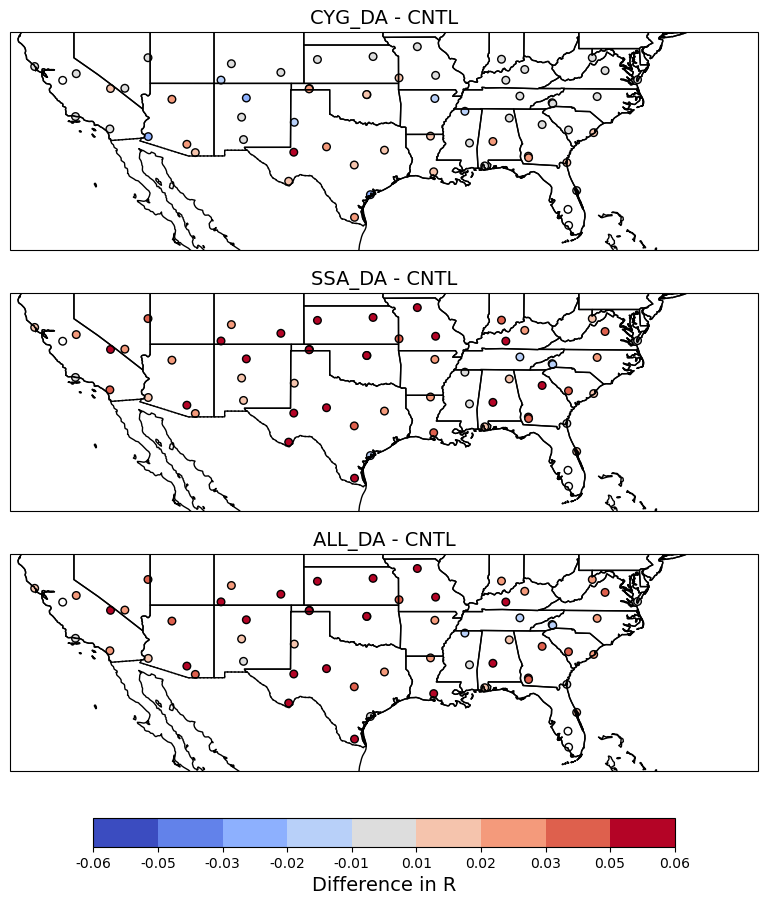

In [15]:

# Calculate the differences in R for surface SM
R_diff_surface_CYG_DA = R[:, 0, 1] - R[:, 0, 0]  # CYG_DA - CNTL
R_diff_surface_SSA_DA = R[:, 0, 2] - R[:, 0, 0]  # SSA_DA - CNTL
R_diff_surface_ALL_DA = R[:, 0, 3] - R[:, 0, 0]  # ALL_DA - CNTL

# Define discrete color levels
levels = np.linspace(-0.06, 0.06, 10)
cmap = plt.cm.get_cmap('coolwarm', len(levels) - 1)  # Discrete colormap

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles for the subplots
titles = ['CYG_DA - CNTL', 'SSA_DA - CNTL', 'ALL_DA - CNTL']

# Data for each subplot
R_diff_data = [R_diff_surface_CYG_DA, R_diff_surface_SSA_DA, R_diff_surface_ALL_DA]

for ax, diff_data, title in zip(axs, R_diff_data, titles):
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, edgecolor='black')  # Add state boundaries

    # Set extent to show all of CONUS
    ax.set_extent([-125, -66.5, 24, 41], crs=ccrs.PlateCarree())

    # Plot the data
    sc = ax.scatter(INSITU_lon, INSITU_lat, c=diff_data, cmap=cmap, s=30, edgecolor='k',
                    transform=ccrs.PlateCarree(), vmin=levels[0], vmax=levels[-1])
    ax.set_title(title, fontsize=14)

# Add a single colorbar for all subplots
norm = plt.Normalize(vmin=levels[0], vmax=levels[-1])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='horizontal', shrink=0.5, pad=0.05)
cbar.set_label('Difference in R', fontsize=14)
cbar.set_ticks(levels)
cbar.set_ticklabels([f"{lvl:.2f}" for lvl in levels])

# Adjust layout to ensure the colorbar is placed below the maps
#plt.tight_layout()
plt.show()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/2472229306.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', len(levels) - 1)  # Discrete colormap


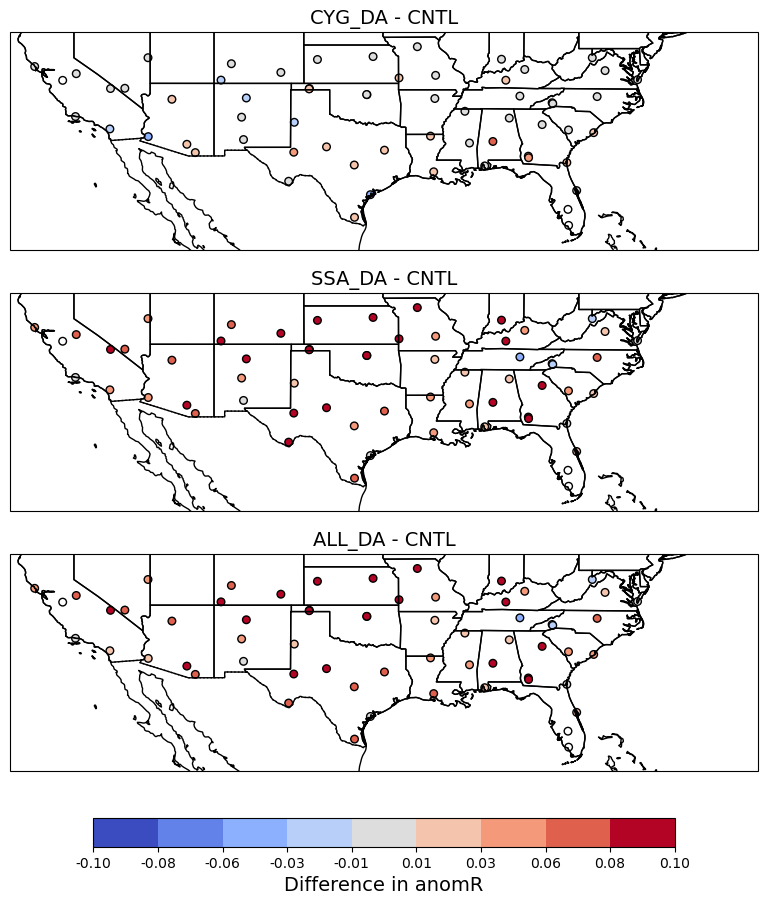

In [16]:
# Calculate the differences in anomR for surface SM
anomR_diff_surface_CYG_DA = anomR[:, 0, 1] - anomR[:, 0, 0]  # CYG_DA - CNTL
anomR_diff_surface_SSA_DA = anomR[:, 0, 2] - anomR[:, 0, 0]  # SSA_DA - CNTL
anomR_diff_surface_ALL_DA = anomR[:, 0, 3] - anomR[:, 0, 0]  # ALL_DA - CNTL

# Define discrete color levels
levels = np.linspace(-0.1, 0.1, 10)
cmap = plt.cm.get_cmap('coolwarm', len(levels) - 1)  # Discrete colormap

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles for the subplots
titles = ['CYG_DA - CNTL', 'SSA_DA - CNTL', 'ALL_DA - CNTL']

# Data for each subplot
anomR_diff_data = [anomR_diff_surface_CYG_DA, anomR_diff_surface_SSA_DA, anomR_diff_surface_ALL_DA]

for ax, diff_data, title in zip(axs, anomR_diff_data, titles):
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, edgecolor='black')  # Add state boundaries

    # Set extent to show all of CONUS
    ax.set_extent([-125, -66.5, 24, 41], crs=ccrs.PlateCarree())

    # Plot the data
    sc = ax.scatter(INSITU_lon, INSITU_lat, c=diff_data, cmap=cmap, s=30, edgecolor='k',
                    transform=ccrs.PlateCarree(), vmin=levels[0], vmax=levels[-1])
    ax.set_title(title, fontsize=14)

# Add a single colorbar for all subplots
norm = plt.Normalize(vmin=levels[0], vmax=levels[-1])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='horizontal', shrink=0.5, pad=0.05)
cbar.set_label('Difference in anomR', fontsize=14)
cbar.set_ticks(levels)
cbar.set_ticklabels([f"{lvl:.2f}" for lvl in levels])

# Adjust layout to ensure the colorbar is placed below the maps
plt.show()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/1646604503.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r', len(levels) - 1)  # Discrete colormap


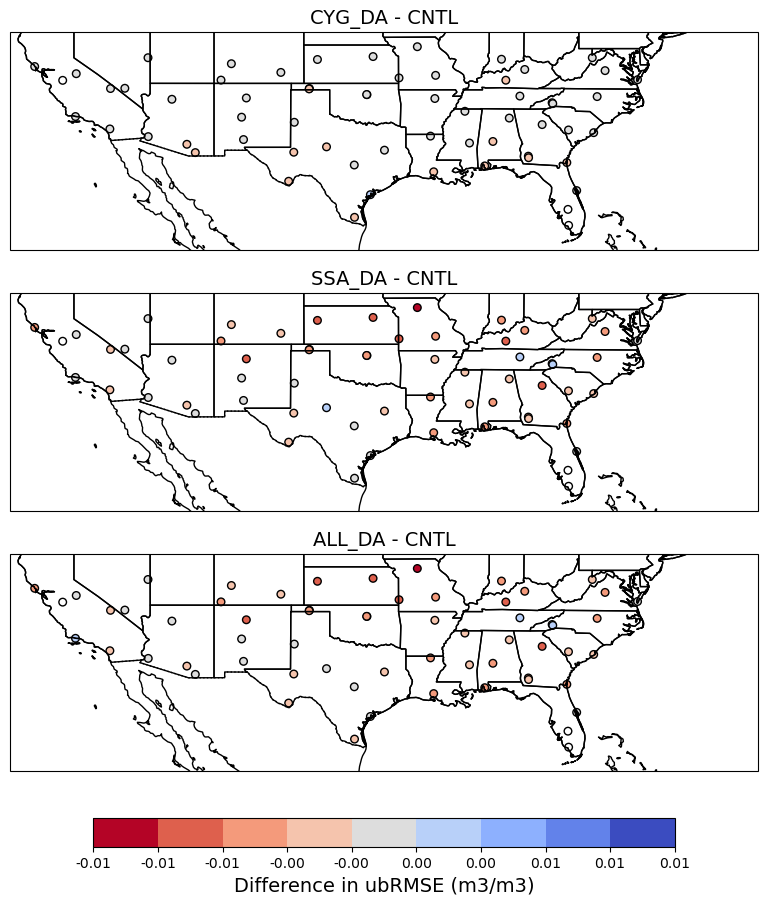

In [17]:
# Calculate the differences in ubRMSE for surface SM
ubRMSE_diff_surface_CYG_DA = ubRMSE[:, 0, 1] - ubRMSE[:, 0, 0]  # CYG_DA - CNTL
ubRMSE_diff_surface_SSA_DA = ubRMSE[:, 0, 2] - ubRMSE[:, 0, 0]  # SSA_DA - CNTL
ubRMSE_diff_surface_ALL_DA = ubRMSE[:, 0, 3] - ubRMSE[:, 0, 0]  # ALL_DA - CNTL

# Define discrete color levels
levels = np.linspace(-0.01, 0.01, 10)
cmap = plt.cm.get_cmap('coolwarm_r', len(levels) - 1)  # Discrete colormap

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles for the subplots
titles = ['CYG_DA - CNTL', 'SSA_DA - CNTL', 'ALL_DA - CNTL']

# Data for each subplot
ubRMSE_diff_data = [ubRMSE_diff_surface_CYG_DA, ubRMSE_diff_surface_SSA_DA, ubRMSE_diff_surface_ALL_DA]

for ax, diff_data, title in zip(axs, ubRMSE_diff_data, titles):
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, edgecolor='black')  # Add state boundaries

    # Set extent to show all of CONUS
    ax.set_extent([-125, -66.5, 24, 41], crs=ccrs.PlateCarree())

    # Plot the data
    sc = ax.scatter(INSITU_lon, INSITU_lat, c=diff_data, cmap=cmap, s=30, edgecolor='k',
                    transform=ccrs.PlateCarree(), vmin=levels[0], vmax=levels[-1])
    ax.set_title(title, fontsize=14)

# Add a single colorbar for all subplots
norm = plt.Normalize(vmin=levels[0], vmax=levels[-1])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='horizontal', shrink=0.5, pad=0.05)
cbar.set_label('Difference in ubRMSE (m3/m3)', fontsize=14)
cbar.set_ticks(levels)
cbar.set_ticklabels([f"{lvl:.2f}" for lvl in levels])

# Adjust layout to ensure the colorbar is placed below the maps
plt.show()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/1971413894.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/1971413894.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  get_cmap('RdBu_r', len(levels_anomR)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/1971413894.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instea

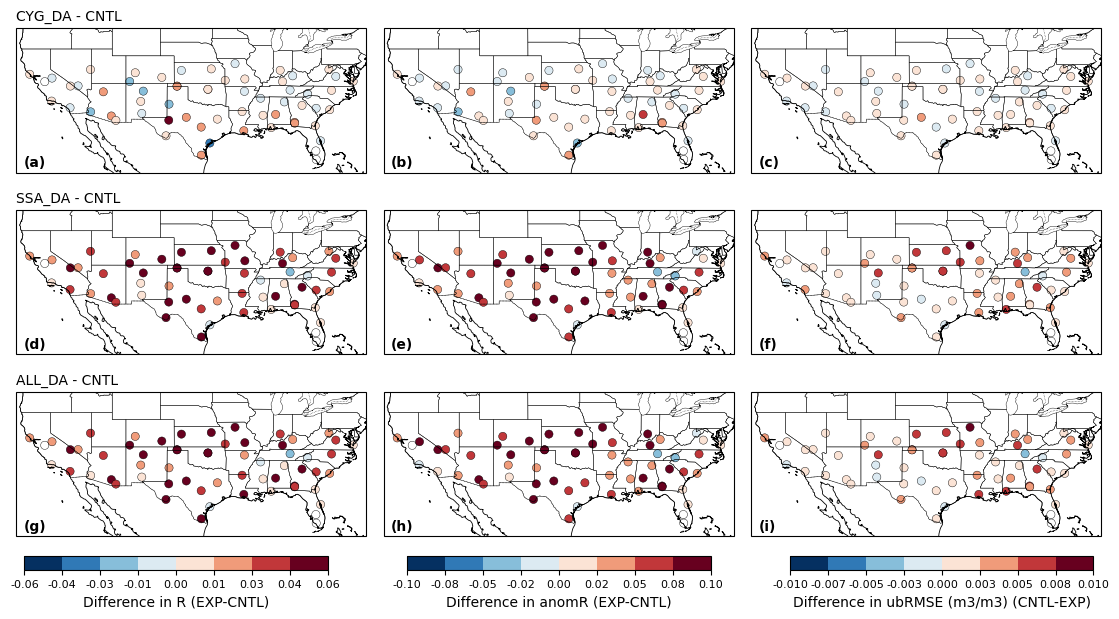

In [ ]:
# Combined 3x3 maps: ΔR, ΔanomR, ΔubRMSE (surface) — formatted like example
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

# Diff arrays (surface depth = 0)
rows = [
    ('CYG_DA - CNTL', 1),
    ('SSA_DA - CNTL', 2),
    ('ALL_DA - CNTL', 3),
]

# Levels and colormaps per column
levels_R = np.linspace(-0.06, 0.06, 9)
levels_anomR = np.linspace(-0.10, 0.10, 9)
levels_ub = np.linspace(-0.01, 0.01, 9)
cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
         get_cmap('RdBu_r', len(levels_anomR)-1),
         get_cmap('RdBu_r',   len(levels_ub)-1)]
levels_list = [levels_R, levels_anomR, levels_ub]
titles_col = ['Difference in R (EXP-CNTL)', 'Difference in anomR (EXP-CNTL)', 'Difference in ubRMSE (m3/m3) (CNTL-EXP)']
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

fig, axes = plt.subplots(3, 3, figsize=(14, 7), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.reshape(3,3)

lab_idx = 0
for r_idx, (row_title, exp_idx) in enumerate(rows):
    for c_idx, (metric, levels, cmap) in enumerate(zip(['R','anomR','ubRMSE'], levels_list, cmaps)):
        ax = axes[r_idx, c_idx]
        if metric == 'R':
            data = R[:, 0, exp_idx] - R[:, 0, 0]
        elif metric == 'anomR':
            data = anomR[:, 0, exp_idx] - anomR[:, 0, 0]
        else:
            data = ubRMSE[:, 0, 0] - ubRMSE[:, 0, exp_idx]
        norm = BoundaryNorm(levels, cmap.N)
        sc = ax.scatter(INSITU_lon, INSITU_lat, c=data, cmap=cmap, norm=norm,
                        s=35, edgecolor='k', linewidths=0.3, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=':')
        ax.add_feature(cfeature.STATES, linewidth=0.3)
        ax.set_extent([-125, -74, 24, 45], crs=ccrs.PlateCarree())
        ax.set_title(row_title if c_idx == 0 else '', fontsize=10, loc='left')
        ax.tick_params(labelbottom=False, labelleft=False)

# Colorbars under each column, 95% width centered and closer to panels
cbar_h = 0.02
# anchor relative to bottom row of panels
bottom_row = axes[-1, :]
y_min = min(ax.get_position().y0 for ax in bottom_row)
gap = 0.02  # gap between panels and colorbars
cbar_y = y_min - gap - cbar_h

for levels, cmap, title, col_ax in zip(levels_list, cmaps, titles_col, axes.T):
    x0 = min(ax.get_position().x0 for ax in col_ax)
    x1 = max(ax.get_position().x1 for ax in col_ax)
    span = x1 - x0
    width = 0.95 * span
    xpos = x0 + 0.5 * (span - width)
    norm = BoundaryNorm(levels, cmap.N)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = fig.add_axes([xpos, cbar_y, width, cbar_h])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(title, fontsize=10)
    cbar.set_ticks(levels)
    if 'ubRMSE' in title:
        cbar.ax.set_xticklabels([f"{lvl:.3f}" for lvl in levels], fontsize=8)
    else:
        cbar.ax.set_xticklabels([f"{lvl:.2f}" for lvl in levels], fontsize=8)

plt.subplots_adjust(wspace=0.05, hspace=0.08, bottom=0.12)
plt.show()


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/1235005324.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/1235005324.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  get_cmap('RdBu_r', len(levels_anomR)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/1235005324.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instea

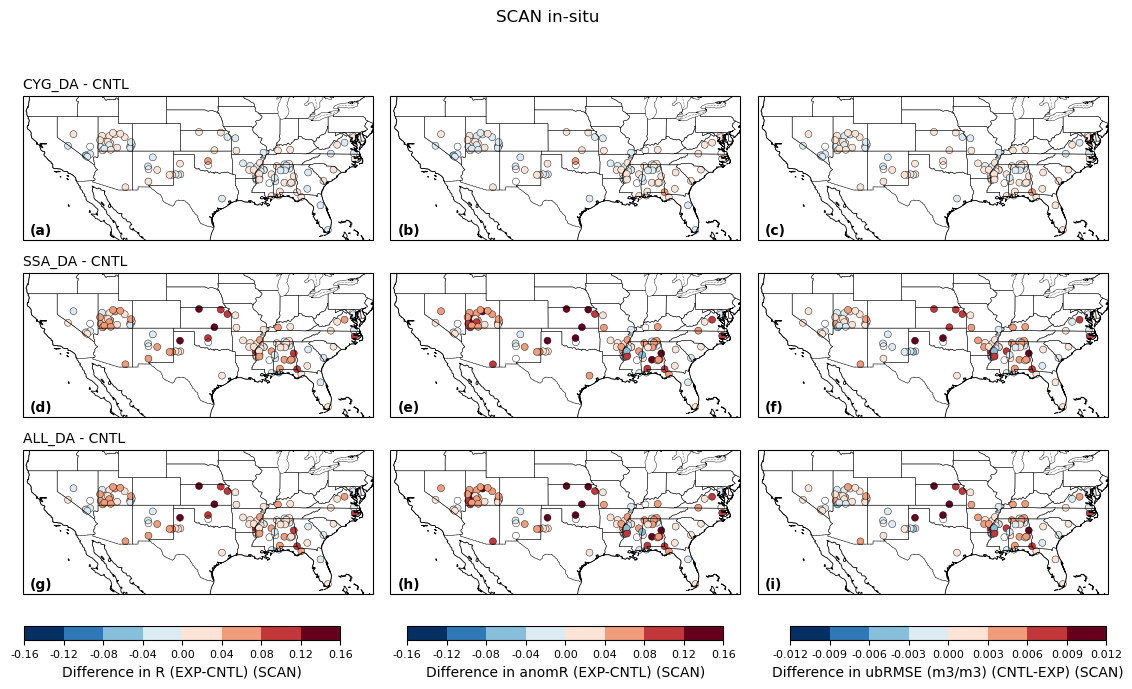

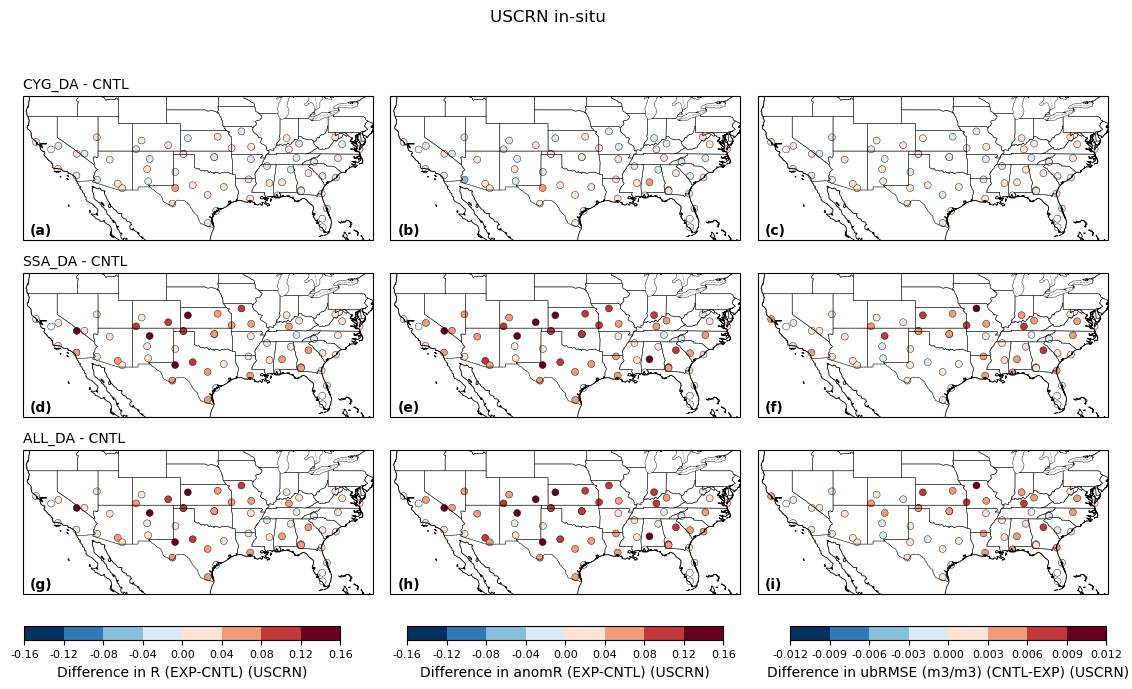

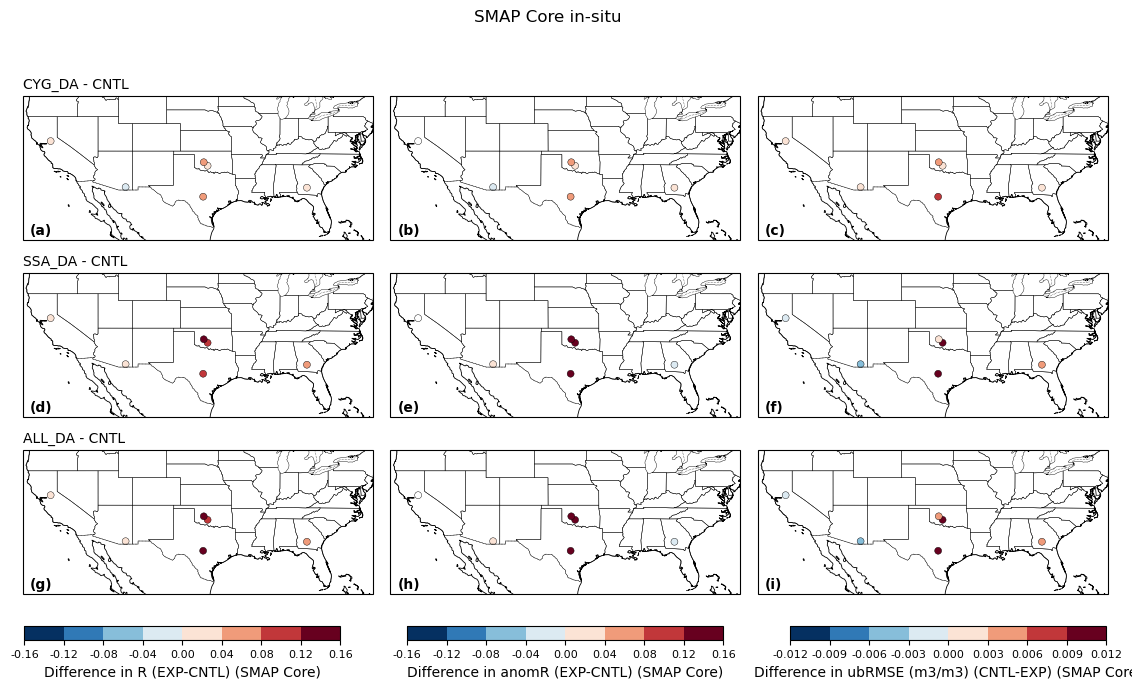

In [19]:
# Combined 3x3 maps for each in-situ network (using networks list)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

# Helper to plot one network
levels_R = np.linspace(-0.16, 0.16, 9)
levels_anomR = np.linspace(-0.16, 0.16, 9)
levels_ub = np.linspace(-0.012, 0.012, 9)
cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
         get_cmap('RdBu_r', len(levels_anomR)-1),
         get_cmap('RdBu_r',   len(levels_ub)-1)]
levels_list = [levels_R, levels_anomR, levels_ub]
titles_col = ['Difference in R (EXP-CNTL)', 'Difference in anomR (EXP-CNTL)', 'Difference in ubRMSE (m3/m3) (CNTL-EXP)']
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

rows = [
    ('CYG_DA - CNTL', 1),
    ('SSA_DA - CNTL', 2),
    ('ALL_DA - CNTL', 3),
]


def plot_network_combined(network_tag: str, network_label: str):
    # Find matching network index from preloaded networks list
    try:
        network_idx = next(i for i, (tag, _) in enumerate(networks) if tag == network_tag)
    except StopIteration:
        raise ValueError(f"Network tag {network_tag} not found in networks={networks}")

    R_net = np.stack(store_R[network_idx], axis=-1)
    anomR_net = np.stack(store_anomR[network_idx], axis=-1)
    ubRMSE_net = np.stack(store_ub[network_idx], axis=-1)

    # Determine control prefix from earlier config
    if 'experiment_names' in globals():
        control_prefix = experiment_names[0]
    elif 'experiments' in globals():
        control_prefix = experiments[0]['prefix']
    else:
        raise NameError('experiment_names/experiments not defined; run setup cells first')

    raw_path = BASE_DIR / f"{control_prefix}{network_tag}_raw_timeseries.mat"
    mat_raw = sio.loadmat(raw_path, squeeze_me=False)
    INSITU_lat = mat_raw['INSITU_lat'].flatten()
    INSITU_lon = mat_raw['INSITU_lon'].flatten()

    fig, axes = plt.subplots(3, 3, figsize=(14, 7), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.reshape(3, 3)
    lab_idx = 0
    for r_idx, (row_title, exp_idx) in enumerate(rows):
        for c_idx, (metric, levels, cmap) in enumerate(zip(['R', 'anomR', 'ubRMSE'], levels_list, cmaps)):
            ax = axes[r_idx, c_idx]
            if metric == 'R':
                data = R_net[:, 0, exp_idx] - R_net[:, 0, 0]
            elif metric == 'anomR':
                data = anomR_net[:, 0, exp_idx] - anomR_net[:, 0, 0]
            else:
                data = ubRMSE_net[:, 0, 0] - ubRMSE_net[:, 0, exp_idx]
            norm = BoundaryNorm(levels, cmap.N)
            sc = ax.scatter(INSITU_lon, INSITU_lat, c=data, cmap=cmap, norm=norm,
                            s=25, edgecolor='k', linewidths=0.3, transform=ccrs.PlateCarree())
            ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
            ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=':')
            ax.add_feature(cfeature.STATES, linewidth=0.3)
            ax.set_extent([-125, -74, 24, 45], crs=ccrs.PlateCarree())
            ax.set_title(row_title if c_idx == 0 else '', fontsize=10, loc='left')
            ax.tick_params(labelbottom=False, labelleft=False)
            ax.text(0.02, 0.02, labels[lab_idx], transform=ax.transAxes,
                    fontsize=10, fontweight='bold', va='bottom', ha='left')
            lab_idx += 1

    # Colorbars under each column
    cbar_h = 0.02
    bottom_row = axes[-1, :]
    y_min = min(ax.get_position().y0 for ax in bottom_row)
    gap = 0.02
    cbar_y = y_min - gap - cbar_h
    for levels, cmap, title, col_ax in zip(levels_list, cmaps, titles_col, axes.T):
        x0 = min(ax.get_position().x0 for ax in col_ax)
        x1 = max(ax.get_position().x1 for ax in col_ax)
        span = x1 - x0
        width = 0.99 * span
        xpos = x0 + 0.5 * (span - width)
        norm = BoundaryNorm(levels, cmap.N)
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        cax = fig.add_axes([xpos, cbar_y, width, cbar_h])
        cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
        cbar.set_label(f"{title} ({network_label})", fontsize=10)
        cbar.set_ticks(levels)
        if title.startswith('Difference in ubRMSE'):
            cbar.ax.set_xticklabels([f"{lvl:.3f}" for lvl in levels], fontsize=8)
        else:
            cbar.ax.set_xticklabels([f"{lvl:.2f}" for lvl in levels], fontsize=8)

    plt.subplots_adjust(wspace=0.05, hspace=0.08, bottom=0.14)
    plt.suptitle(f"{network_label} in-situ", fontsize=12, y=0.99)
    plt.show()

# Plot for each network from the predefined networks list
for tag, nlabel in networks:
    plot_network_combined(tag, nlabel)


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/1305501875.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/1305501875.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  get_cmap('RdBu_r', len(levels_anomR)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_3854/1305501875.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instea

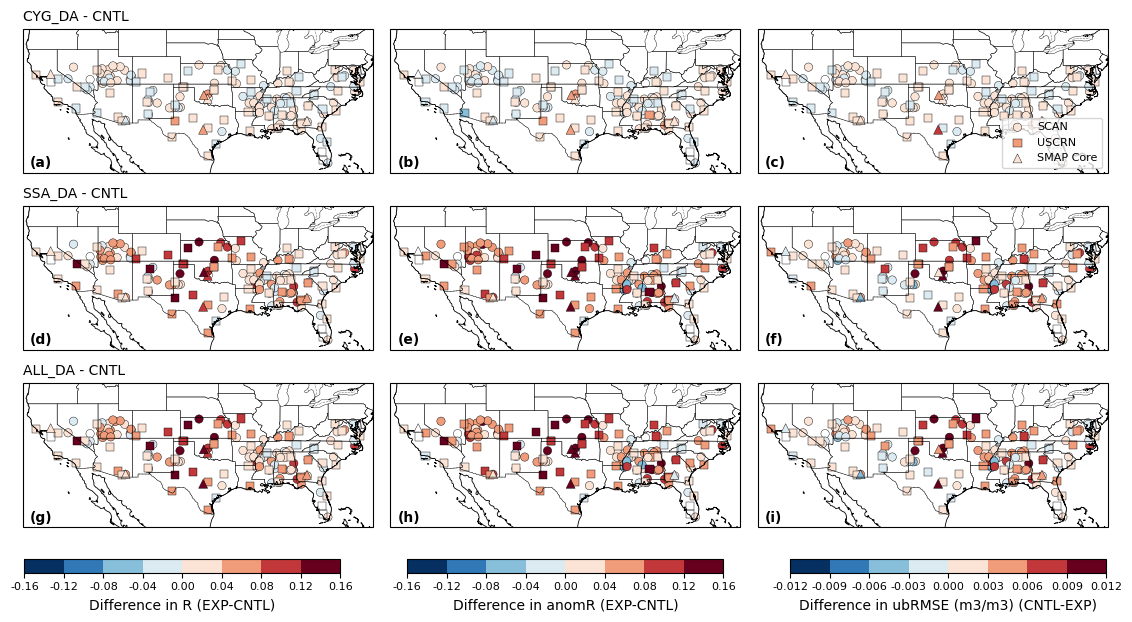

In [20]:
# Combined 3x3 overlay for all networks (SCAN, USCRN, SMAP Core) with SMAP on top
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

# Build overlay order using existing networks (use 6yr tags), SMAP drawn last
order_labels = ['SCAN', 'USCRN', 'SMAP Core']
markers = {'SCAN': ('o', 36), 'USCRN': ('s', 34), 'SMAP Core': ('^', 42)}
overlay_networks = []
for lbl in order_labels:
    for tag, nlabel in networks:
        if nlabel == lbl:
            marker, size = markers.get(lbl, ('o', 36))
            overlay_networks.append((tag, nlabel, marker, size))
            break

levels_R = np.linspace(-0.16, 0.16, 9)
levels_anomR = np.linspace(-0.16, 0.16, 9)
levels_ub = np.linspace(-0.012, 0.012, 9)
cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
         get_cmap('RdBu_r', len(levels_anomR)-1),
         get_cmap('RdBu_r',   len(levels_ub)-1)]
levels_list = [levels_R, levels_anomR, levels_ub]
titles_col = ['Difference in R (EXP-CNTL)', 'Difference in anomR (EXP-CNTL)', 'Difference in ubRMSE (m3/m3) (CNTL-EXP)']
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
rows = [
    ('CYG_DA - CNTL', 1),
    ('SSA_DA - CNTL', 2),
    ('ALL_DA - CNTL', 3),
]

# Determine control prefix
if 'experiment_names' in globals():
    control_prefix = experiment_names[0]
elif 'experiments' in globals():
    control_prefix = experiments[0]['prefix']
else:
    raise NameError('experiment_names/experiments not defined; run setup cells first')

# Precompute arrays and lat/lon per network
overlay_data = {}
for tag, nlabel, _, _ in overlay_networks:
    try:
        nidx = next(i for i, (t, _) in enumerate(networks) if t == tag)
    except StopIteration:
        raise ValueError(f'Network tag {tag} not found in networks={networks}')
    overlay_data[tag] = {
        'R': np.stack(store_R[nidx], axis=-1),
        'anomR': np.stack(store_anomR[nidx], axis=-1),
        'ubRMSE': np.stack(store_ub[nidx], axis=-1),
    }
    raw_path = BASE_DIR / f"{control_prefix}{tag}_raw_timeseries.mat"
    mat_raw = sio.loadmat(raw_path, squeeze_me=False)
    overlay_data[tag]['lat'] = mat_raw['INSITU_lat'].flatten()
    overlay_data[tag]['lon'] = mat_raw['INSITU_lon'].flatten()

fig, axes = plt.subplots(3, 3, figsize=(14, 7), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.reshape(3, 3)
lab_idx = 0
legend_handles = None
legend_labels = None
for r_idx, (row_title, exp_idx) in enumerate(rows):
    for c_idx, (metric, levels, cmap) in enumerate(zip(['R', 'anomR', 'ubRMSE'], levels_list, cmaps)):
        ax = axes[r_idx, c_idx]
        norm = BoundaryNorm(levels, cmap.N)
        for tag, nlabel, marker, size in overlay_networks:
            arr = overlay_data[tag][metric]
            if metric == 'ubRMSE':
                data = arr[:, 0, 0] - arr[:, 0, exp_idx]
            else:
                data = arr[:, 0, exp_idx] - arr[:, 0, 0]
            lat = overlay_data[tag]['lat']; lon = overlay_data[tag]['lon']
            sc = ax.scatter(lon, lat, c=data, cmap=cmap, norm=norm, s=size,
                            marker=marker, edgecolor='k', linewidths=0.3,
                            transform=ccrs.PlateCarree(), label=nlabel)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=':')
        ax.add_feature(cfeature.STATES, linewidth=0.3)
        ax.set_extent([-125, -74, 24, 45], crs=ccrs.PlateCarree())
        ax.set_title(row_title if c_idx == 0 else '', fontsize=10, loc='left')
        ax.tick_params(labelbottom=False, labelleft=False)
        ax.text(0.02, 0.02, labels[lab_idx], transform=ax.transAxes,
                fontsize=10, fontweight='bold', va='bottom', ha='left')
        if legend_handles is None:
            legend_handles, legend_labels = ax.get_legend_handles_labels()
        lab_idx += 1

# Add a single legend
if legend_handles:
    axes[0,2].legend(legend_handles, legend_labels, loc='lower right', fontsize=8, frameon=True)

# Colorbars under each column
cbar_h = 0.02
bottom_row = axes[-1, :]
y_min = min(ax.get_position().y0 for ax in bottom_row)
gap = 0.02
cbar_y = y_min - gap - cbar_h
for levels, cmap, title, col_ax in zip(levels_list, cmaps, titles_col, axes.T):
    x0 = min(ax.get_position().x0 for ax in col_ax)
    x1 = max(ax.get_position().x1 for ax in col_ax)
    span = x1 - x0
    width = 0.99 * span
    xpos = x0 + 0.5 * (span - width)
    norm = BoundaryNorm(levels, cmap.N)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = fig.add_axes([xpos, cbar_y, width, cbar_h])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(title, fontsize=10)
    cbar.set_ticks(levels)
    if title.startswith('Difference in ubRMSE'):
        cbar.ax.set_xticklabels([f"{lvl:.3f}" for lvl in levels], fontsize=8)
    else:
        cbar.ax.set_xticklabels([f"{lvl:.2f}" for lvl in levels], fontsize=8)

plt.subplots_adjust(wspace=0.05, hspace=0.08, bottom=0.14)
# plt.suptitle('All networks overlay (SMAP Core on top)', fontsize=12, y=0.99)
plt.show()
